In [1]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import __init__ as spg
import cv2
import anndata as ad

In [2]:
spg.__version__

'1.2.5'

In [3]:
adata9 = sc.read("/home/chentang/data/humanHeart/adata.9_data_lfft_filter_25_17_30x30_002.h5ad")
adata10 = sc.read("/home/chentang/data/humanHeart/adata.10_data_lfft_filter_25_17_30x30_002.h5ad")
adata11 = sc.read("/home/chentang/data/humanHeart/adata.11_data_lfft_filter_25_17_30x30_002.h5ad")
adata12 = sc.read("/home/chentang/data/humanHeart/adata.12_data_lfft_filter_25_17_30x30_002.h5ad")

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scanpy as sc
import paste as pst

In [5]:
slices = []  
slices.append(adata9)
slices.append(adata10)
slices.append(adata11)
slices.append(adata12)

In [6]:
for j in range(4):
    slices_coor = []
    for i in range(len(slices[j].obs)):
        slice_i_coor = [slices[j].obs['x_pixel'][i], slices[j].obs['y_pixel'][i]]
        slices_coor.append(slice_i_coor)
    slices_coor = np.array(slices_coor)
    slices[j].obsm['spatial'] = slices_coor

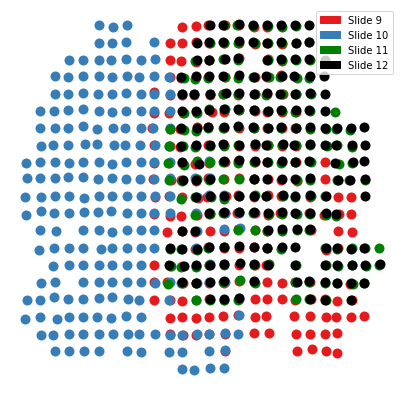

In [7]:
slice_colors = ['#e41a1c','#377eb8','green','black','yellow','grey', "#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370"]
plt.figure(figsize=(7,7))
for i in range(len(slices)):
    pst.plot_slice(slices[i],slice_colors[i],s=400)
plt.legend(handles=[mpatches.Patch(color=slice_colors[0], label='Slide 9'),mpatches.Patch(color=slice_colors[1], label='Slide 10'),mpatches.Patch(color=slice_colors[2], label='Slide 11'),mpatches.Patch(color=slice_colors[3], label='Slide 12')])
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

In [8]:
alpha = 0.1
res_df = pd.DataFrame(columns=['Sample','Pair','Kind','Time','Accuracy'])
pis = [None for i in range(3)]
for i in range(3):
    pi0 = pst.match_spots_using_spatial_heuristic(slices[i].obsm['spatial'],slices[i+1].obsm['spatial'],use_ot=True)
    pis[i] = pst.pairwise_align(slices[i], slices[i+1],alpha=alpha, G_init=pi0, norm=True, verbose=False)

new_slices = pst.stack_slices_pairwise(slices, pis)  
    
new_slices

Using selected backend cpu. If you want to use gpu, set use_gpu = True.
Using selected backend cpu. If you want to use gpu, set use_gpu = True.
Using selected backend cpu. If you want to use gpu, set use_gpu = True.


[AnnData object with n_obs × n_vars = 214 × 39739
     obs: 'nGene', 'nUMI', 'Sample', 'weeks', 'ChipBatch', 'ChipNr', 'Experiment_date', 'Experiment_procedure', 'Sequencing_date', 'Raw_reads', 'new_x', 'new_y', 'percent.mito', 'res.0.8', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'x_pixel_aligned', 'y_pixel_aligned', 'annotation', 'z_array', 'z_pixel', 'z_pixel_aligned'
     var: 'genename'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 209 × 39739
     obs: 'nGene', 'nUMI', 'Sample', 'weeks', 'ChipBatch', 'ChipNr', 'Experiment_date', 'Experiment_procedure', 'Sequencing_date', 'Raw_reads', 'new_x', 'new_y', 'percent.mito', 'res.0.8', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'x_pixel_aligned', 'y_pixel_aligned', 'annotation', 'z_array', 'z_pixel', 'z_pixel_aligned'
     var: 'genename'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 178 × 39739
     obs: 'nGene', 'nUMI', 'Sa

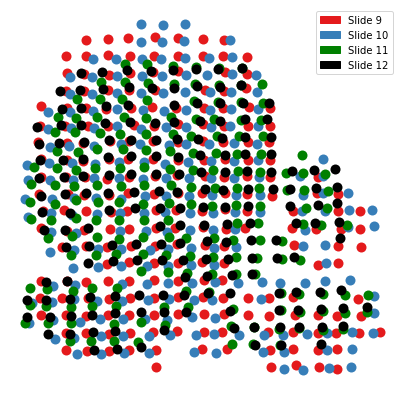

In [9]:
slice_colors = ['#e41a1c','#377eb8','green','black','yellow','grey', "#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370"]
plt.figure(figsize=(7,7))
for i in range(len(new_slices)):
    pst.plot_slice(new_slices[i],slice_colors[i],s=400)
plt.legend(handles=[mpatches.Patch(color=slice_colors[0], label='Slide 9'),mpatches.Patch(color=slice_colors[1], label='Slide 10'),mpatches.Patch(color=slice_colors[2], label='Slide 11'),mpatches.Patch(color=slice_colors[3], label='Slide 12')])
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()

In [10]:
x_min = 0
y_min = 0

for j in range(4):
    for i in range(len(slices[j].obs)):
        x = new_slices[j].obsm['spatial'][i][0]
        y = new_slices[j].obsm['spatial'][i][1]
        
        if x_min > x:
            x_min = x
        if y_min > y:
            y_min = y
            
print(x_min, y_min)

-1423.4706435395126 -2257.8469551453077


In [11]:
for j in range(4):
    for i in range(len(slices[j].obs)):
        x = new_slices[j].obsm['spatial'][i][0] - x_min
        y = new_slices[j].obsm['spatial'][i][1] - y_min
        
        new_slices[j].obsm['spatial'][i][0] = x
        new_slices[j].obsm['spatial'][i][1] = y

In [12]:
for j in range(4):
    slices_coor = []
    for i in range(len(slices[j].obs)):
        slices[j].obs["x_pixel_aligned"][i] = new_slices[j].obsm['spatial'][i][0]
        slices[j].obs["y_pixel_aligned"][i] = new_slices[j].obsm['spatial'][i][1]

In [13]:
from sklearn.neighbors import NearestNeighbors

def get_coords(index):

    coords = pd.DataFrame(index=index)
    coords['x'] = index.str.split('x').str.get(0).map(float)
    coords['y'] = index.str.split('x').str.get(1).map(float)
    
    return coords

In [14]:
a = []

for j in range(4):
    df = slices[j].to_df(layer=None)
    df.index = slices[j].obs["x_pixel_aligned"].astype(str) + "x" + slices[j].obs["y_pixel_aligned"].astype(str)
    sample_info_position = get_coords(df.index)

    para_neighbors = 2
    nbrs = NearestNeighbors(n_neighbors = para_neighbors, algorithm='ball_tree').fit(sample_info_position)
    distances, indices = nbrs.kneighbors(sample_info_position)
    for i in range(len(distances)):
        a.append(distances[i][1])
np.median(a)

197.4000000000001

In [15]:
for j in range(4):
    slices_coor = []
    for i in range(len(slices[j].obs)):
        new_slices[j].obs["x_pixel_aligned"][i] = new_slices[j].obsm['spatial'][i][0] / 197.4 * 200.0
        new_slices[j].obs["y_pixel_aligned"][i] = new_slices[j].obsm['spatial'][i][1] / 197.4 * 200.0


In [16]:
adata9, adata10, adata11, adata12 = new_slices

In [17]:
counts_9 = adata9.to_df(layer=None)
counts_10 = adata10.to_df(layer=None)
counts_11 = adata11.to_df(layer=None)
counts_12 = adata12.to_df(layer=None)

obs_9 = adata9.obs
obs_10 = adata10.obs
obs_11 = adata11.obs
obs_12 = adata12.obs

df = pd.concat([counts_9, counts_10, counts_11, counts_12])
obs = pd.concat([obs_9, obs_10, obs_11, obs_12])
obs['z_pixel_aligned'] = obs['z_pixel']

adata_week6_new = ad.AnnData(df)
adata_week6_new.obs = obs

adata_week6_new.obs

adata_week6_new.write_h5ad("/home/chentang/data/humanHeart/adata3D_week6_part_aligned_lfft_filter_325.h5ad")

... storing 'Sample' as categorical


In [40]:
adata = adata_week6_new
adata.obs

,nGene,nUMI,Sample,weeks,ChipBatch,ChipNr,Experiment_date,Experiment_procedure,Sequencing_date,Raw_reads,...,x_pixel,y_pixel,x_pixel_aligned,y_pixel_aligned,annotation,z_array,z_pixel,z_pixel_aligned,n_counts,pred
9x16x10,2157,4763,FH6_1000L2_CN74_E1,6,1000L2,CN74,150326,manual,150831,86504781,...,3345.3,2100.0,144.283242,1888.143826,0,9,365,365,5713.0,1
9x16x11,2237,5129,FH6_1000L2_CN74_E1,6,1000L2,CN74,150326,manual,150831,86504781,...,3332.7,2303.7,131.517284,2094.526805,0,9,365,365,6181.0,1
9x16x12,2550,5939,FH6_1000L2_CN74_E1,6,1000L2,CN74,150326,manual,150831,86504781,...,3366.3,2513.7,165.559837,2307.292762,9,9,365,365,6960.0,1
9x16x13,1387,2550,FH6_1000L2_CN74_E1,6,1000L2,CN74,150326,manual,150831,86504781,...,3353.7,2725.8,152.793880,2522.186379,9,9,365,365,3039.0,1
9x16x16,1451,2954,FH6_1000L2_CN74_E1,6,1000L2,CN74,150326,manual,150831,86504781,...,3351.6,3360.0,150.666220,3164.739571,8,9,365,365,4628.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12x31x16,3507,7618,FH6_1000L2_CN74_D2,6,1000L2,CN74,150326,manual,151023,76964748,...,6497.4,3349.5,2970.219397,3501.085635,7,12,535,535,8750.0,0
12x31x17,2755,5352,FH6_1000L2_CN74_D2,6,1000L2,CN74,150326,manual,151023,76964748,...,6491.1,3574.2,2971.603975,3728.830464,7,12,535,535,6973.0,0
12x31x8,2195,4956,FH6_1000L2_CN74_D2,6,1000L2,CN74,150326,manual,151023,76964748,...,6484.8,1661.1,2899.123202,1791.877723,4,12,535,535,6008.0,2
12x31x9,1587,3367,FH6_1000L2_CN74_D2,6,1000L2,CN74,150326,manual,151023,76964748,...,6495.3,1879.5,2917.301478,2012.662812,8,12,535,535,5274.0,6


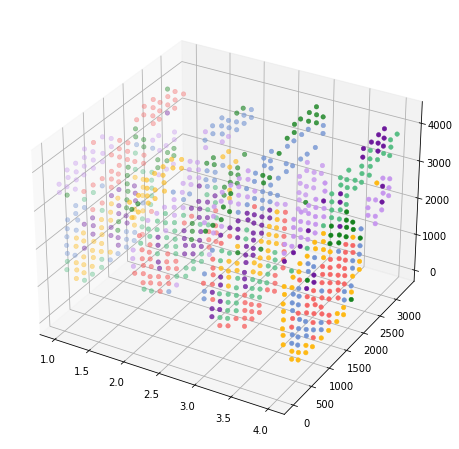

In [41]:
plot_color=["#F56867","#59BE86","#6D1A9C","#7495D3","#FEB915","#C798EE","#D1D1D1","#877F6C","#E1E1E1",]
filled_markers = ['o', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'v', '^', '<', '>', '8', 's', 'p']

plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
x_array = adata.obs["x_array"]
y_array = adata.obs["y_array"]
z_array = 13 - adata.obs["z_array"]
z_array_cluster = set(z_array.to_list())
x_pixel = adata.obs["x_pixel_aligned"]
y_pixel = adata.obs["y_pixel_aligned"]
z_pixel = adata.obs["z_pixel"]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

dict_x_pixel = {}
dict_y_pixel = {}
dict_z_array = {}
pred = adata.obs["pred"].to_numpy()
cluster = set(pred)


for j in z_array_cluster:
    
    i = 0

    for id in cluster:
        dict_x_pixel[id] = x_pixel[(pred == id) & (z_array == j)].tolist()
        dict_y_pixel[id] = y_pixel[(pred == id) & (z_array == j)].tolist()
        dict_z_array[id] = z_array[(pred == id) & (z_array == j)].tolist()
        # ax.axes.invert_yaxis()
        ax.scatter(dict_z_array[id], dict_x_pixel[id],dict_y_pixel[id], c=plot_color[i], marker=filled_markers[0], alpha = 0.2 + 0.2 * j, linewidths = 0.5)
        i = i + 1

In [42]:
from sklearn.metrics.cluster import adjusted_rand_score

domains1="pred"
domains2="annotation"
a = adata.obs[domains1].to_numpy()
b = adata.obs[domains2].to_numpy()
n = len(b)
a = a.astype(float)
b = b.astype(float)
b[np.isnan(b)] = 0

adjusted_rand_score(a, b)

0.12993514565820038

In [82]:
adata_week6_new.obs

,nGene,nUMI,Sample,weeks,ChipBatch,ChipNr,Experiment_date,Experiment_procedure,Sequencing_date,Raw_reads,...,x_array,y_array,x_pixel,y_pixel,x_pixel_aligned,y_pixel_aligned,annotation,z_array,z_pixel,z_pixel_aligned
9x16x10,2157,4763,FH6_1000L2_CN74_E1,6,1000L2,CN74,150326,manual,150831,86504781,...,16,16,3345.3,2100.0,146.724409,1888.263616,0,9,365,365
9x16x11,2237,5129,FH6_1000L2_CN74_E1,6,1000L2,CN74,150326,manual,150831,86504781,...,16,16,3332.7,2303.7,133.958451,2094.646595,0,9,365,365
9x16x12,2550,5939,FH6_1000L2_CN74_E1,6,1000L2,CN74,150326,manual,150831,86504781,...,16,16,3366.3,2513.7,168.001005,2307.412553,9,9,365,365
9x16x13,1387,2550,FH6_1000L2_CN74_E1,6,1000L2,CN74,150326,manual,150831,86504781,...,16,16,3353.7,2725.8,155.235047,2522.306170,9,9,365,365
9x16x16,1451,2954,FH6_1000L2_CN74_E1,6,1000L2,CN74,150326,manual,150831,86504781,...,16,16,3351.6,3360.0,153.107388,3164.859361,8,9,365,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12x31x16,3507,7618,FH6_1000L2_CN74_D2,6,1000L2,CN74,150326,manual,151023,76964748,...,31,31,6497.4,3349.5,2980.166066,3491.684389,7,12,535,535
12x31x17,2755,5352,FH6_1000L2_CN74_D2,6,1000L2,CN74,150326,manual,151023,76964748,...,31,31,6491.1,3574.2,2982.964824,3719.416230,7,12,535,535
12x31x8,2195,4956,FH6_1000L2_CN74_D2,6,1000L2,CN74,150326,manual,151023,76964748,...,31,31,6484.8,1661.1,2898.457717,1782.950911,4,12,535,535
12x31x9,1587,3367,FH6_1000L2_CN74_D2,6,1000L2,CN74,150326,manual,151023,76964748,...,31,31,6495.3,1879.5,2918.006632,2003.618863,8,12,535,535
